# PROJECT-3 EDA + Feature Engineering

## 1. Введение

Задача для дата-сайентиста в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Поставлена задача создать такую модель.

## 2. Предварительный анализ данных 

В этом модуле работа проводится с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Предварительно он раз разделен на два файла, содержащие тренировачную и тестовую выборки в отдельных файлах, загруженных  в текущую директорию. Модель, которую необходимо обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. 

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
 # Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 # Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 
import seaborn as sns
import matplotlib.pyplot as plt #для визуализации
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import date
import category_encoders as ce

In [2]:
# прочитаем файл тренировачной выборки
hotels_df_train = pd.read_csv(r'hotels_train.csv')
hotels_train = hotels_df_train.copy()
hotels_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845377,2.325643


Исходный датасет содержит 17 полей со следующей информацией:

hotel_address — адрес отеля;
review_date — дата, когда рецензент разместил соответствующий отзыв;
average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
hotel_name — название отеля;
reviewer_nationality — страна рецензента;
negative_review— отрицательный отзыв, который рецензент дал отелю;
review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
positive_review — положительный отзыв, который рецензент дал отелю;
review_total_positive_word_counts — общее количество слов в положительном отзыве.
reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
total_number_of_reviews — общее количество действительных отзывов об отеле;
tags — теги, которые рецензент дал отелю;
days_since_review — количество дней между датой проверки и датой очистки;
additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
lat — географическая широта отеля;
lng — географическая долгота отеля.

In [3]:
# прочитаем файл тестовой выборки
hotels_df_test = pd.read_csv(r'hotels_test.csv')
hotels_test = hotels_df_test.copy()
hotels_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393192,2.161520


In [4]:
# получим информацию по тренировачному датасету
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
# получим информацию по тестовому датасету
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Тренировочный датасет состоит из 386803 строк и 17 столбцов, в двух столбцах имеются пропущенные значения: lat — географическая широта отеля и lng — географическая долгота отеля, девять столбцов представлены в виже числовых данных в форматах float64(4 столбца), int64(5 столбцов), остальные 8 столбцов в формате object. Тестовый датасет состоит 128935 из строк и 16 столбцов(без целевого).

In [6]:
# образец сабмишен
sample_submission = pd.read_csv(r'submission.csv')
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


## 3. Машинное обучение

In [8]:
# Разбиваем тренировачный датафрейм на части, необходимые для обучения и тестирования модели  
# X_trn- данные с информацией об отелях, y_trn - целевая переменная (рейтинги отелей)  
X_trn = hotels_train.drop(['reviewer_score'], axis = 1)
y_trn = hotels_train['reviewer_score']

In [9]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X_trn, y_trn, test_size=0.25, random_state=42)

В качестве модели будеи использовать RandomForestRegressor. Для этого все данные в датафрейме должны быть в числовых форматах int или float, и в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения необходимо вычислить и поместить в ячейку максимально близкое к реальности значение.
На первом этапе для создания такого датафрейма  удалим столбцы, содержащие данные типов object и заполним пропущенные значения каким-то одним значением, например,   нулём для всего столбца.

In [10]:
object_columns_train = [s for s in X_train_tr.columns if X_train_tr[s].dtypes == 'object']
object_columns_test = [s for s in X_test_tr.columns if X_test_tr[s].dtypes == 'object']
X_train_tr = X_train_tr.drop(object_columns_train, axis = 1).fillna(0)
X_test_tr = X_test_tr.drop(object_columns_test, axis = 1).fillna(0)
# сформируем тестовый набор для сабмишена
X_test_ts = hotels_test.drop(object_columns_train, axis = 1).fillna(0)

In [11]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)    
# Обучаем модель   
regr.fit(X_train_tr, y_train_tr)       
 
# Предсказанные значения по тестовой выборке записываем в переменную y_pred  
y_pred = regr.predict(X_test_tr)
# Оцениваем качество модели по метрике MAPE, сравниваем предсказанные значения (y_pred) с реальными (y_test_tr)
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test_tr, y_pred):.4f}')

MAPE:0.1414


In [12]:
# предсказания для сабмишена
y_pred_test = regr.predict(X_test_ts)
# сформируем сабмишен
sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('base_submission.csv', index=False)

Сабмишен показал результат Score: 14.18203

In [13]:
# ДЛя корректной обработки признаков объединяем train и test в один датасет
hotels_train['sample'] = 1 # помечаем где у нас train
hotels_test['sample'] = 0 # помечаем где у нас test
hotels_test['reviewer_score'] = 0 # в test у нас нет значения reviewer_score, поэтому просто заполняем нулями

hotels = pd.concat([hotels_train, hotels_test], axis=0, ignore_index=True) # объединяем
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [14]:
# преобразуем признак review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# выделим из адреса отеля страну и город и создадим новые признаки
hotels['hotel_address_country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1])
hotels['hotel_address_country'] = hotels['hotel_address_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
hotels['hotel_address_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2] )
# обработаем days_since_review выделив количество дней, преобразуем в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

In [15]:
# создадим бинарный признак из reviewer_nationality и hotel_address_country -  он будет показывать является ли рецензент резидентом данной страны
def resident(address_country, nationality):
    """ Возвращает бинарный признак резидентности рецензента
    1 - резидент, 0 - нерезидент
    по результатам сравнения страны отеля и страны рецензента
        
    """
    nationality = nationality.split(' ')
    
    if nationality[-2]=='Kingdom':
        nationality = ''.join([nationality[1], ' ', nationality[2]])
        if address_country == nationality:
            return 1
        else:
            return 0
    else:
        if address_country == nationality[1]:
            return 1
        else:
            return 0
hotels['resident'] = hotels.apply(lambda x: resident(x.hotel_address_country, x.reviewer_nationality), axis=1)   

**Обработка пропущенных значений**

Пропущенные значения имеются в двух столбцах координат - 'lat' и 'lng'. Заполним пропуски средним значением координат соответствующего города.

In [16]:
# составляем словари, где ключи название городов, значения - средние значение координаты по городу
city_lat = dict(hotels.groupby(['hotel_address_city'])['lat'].mean())
city_lng = dict(hotels.groupby(['hotel_address_city'])['lng'].mean())

def change(city, coordinate):
    """Заменяет пропуски в координате coordinate и возвращает 
    среднее значение координаты float64 по конкретному городу city
    
    """
    if str(coordinate) == 'nan':
        coordinate = city_lat[city]
        return coordinate
    else:
        return coordinate
# заполняем пропуски
hotels['lat'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lat), axis=1)
hotels['lng'] = hotels.apply(lambda x: change(x.hotel_address_city, x.lng), axis=1)

Cоздадим новый признак определяющий долю туристов, поставившие оценку(additional_number_of_scoring), но не оставившие отзыв, от общего числа туристов оставивших отзыв.

In [17]:
hotels['score without reviews'] = round(hotels['additional_number_of_scoring'] / hotels['total_number_of_reviews'], 2)

Обработаем признак tags, для этого сначала создадим функцию tags_info очистки от лишних символов.

In [18]:
def tags_split(tags):
    """Обрабатывает признак, преобразуя из строкового значения в лист с разделенными тэгами,
    удаляя ненужных символы

    """
    number = ['0', '1,' '2', '3', '4', '5', '6', '7', '8', '9', '0']
    for sim in tags:
        if sim.isalpha() is False and sim != ' ' and sim != ',' and sim not in number:
            tags = tags.replace(sim, '')
    tags = tags.split(',')
    return tags

In [19]:
# применим функцию tags_split к нашему признаку
hotels['tags'] = hotels['tags'].apply(tags_split)

На основе признака 'tags' создадим ещё пять признаков. Если проанализировать содержание тэга, то видим, что на первом месте идёт цель поездки(на его основе создадим признак purpose of the trip), на втором месте - турист останавливался один в отеле или нет(новый признак назовём form of recreation), на третьем месте категория номера(новый признак room category), на четвёртом месте информация о количестве ночей(новый признак назовём count_night), на пятом месте стоит информация о том каким образом был оставлен отзыв(новый признак device).

In [20]:
# цель поездки
hotels['purpose of the trip'] = hotels['tags'].apply(lambda x: x[0].strip(' '))
# останавливается один или нет
hotels['form of recreation'] = hotels['tags'].apply(lambda x: x[1].strip(' ') if len(x)>2 else 0)
# категория номера
hotels['room category'] = hotels['tags'].apply(lambda x: x[2].strip(' ') if len(x)>3 else 0)
# количество ночей
hotels['count_night'] = hotels['tags'].apply(lambda x: x[3].strip(' ') if len(x)>=4 else 0)
# дообработка признаков
hotels['purpose of the trip'] = hotels['purpose of the trip'].apply(lambda x: x if x in ['Leisure trip', 'Business trip'] else 'Leisure trip')
hotels['form of recreation'] = hotels['form of recreation'].apply(lambda x: x if x in ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends']
                                                                  else 'Couple')
hotels['room category'] = hotels['room category'].apply(lambda x: 'Double Room' if x ==0 else x)

dict_room = {}
def get_room(room):
    """счётчик категорий по данному признаку, 
    формирует словарь -  категория:кол-во

    Args:
        room (any): категория
    """
    n = 1
    if room not in dict_room.keys():
        dict_room.update({room:n})
    else:
        dict_room[room] = dict_room[room]+1
# считаем количество категорий по признаку room category, данные сохранены в словарь dict_room
hotels['room category'].apply(get_room)
# в признаке room category, если признак встречается редко(<1000), то заменяем на 'other'    
hotels['room category'] = hotels['room category'].apply(lambda x: x if dict_room[x]>1000 else 'other')

# создадим словарь ночей
night = {'Stayed  night': 1, 'Stayed  nights': 2, 'Stayed 3 nights': 3, 'Stayed 4 nights': 4, 'Stayed 5 nights': 5,
         'Stayed 6 nights' : 6, 'Stayed 7 nights' : 7, 'Stayed 8 nights': 8, 'Stayed 9 nights' : 9}
# создадим новый признак count_night
hotels['count_night'] = hotels['count_night'].apply(lambda x: night[x] if x in night.keys() else 1)

# создаём признак device показывающий через какое устройство был оставлен отзыв и обрабатываем
hotels['device'] = hotels['tags'].apply(lambda x: x[-1].strip(' '))
hotels['device']= hotels['device'].apply(lambda x: x if x == 'Submitted from a mobile device' else 'Computer')
hotels['device'] = hotels['device'].apply(lambda x:1 if x == 'Submitted from a mobile device' else 0)

# обработаем признак review_date как период, отражающий кол-во дней - разницы между сегодняшним днём и даты отзыва
today = date.today()
hotels['review_date'] = (pd.to_datetime(today) - hotels['review_date']).dt.days

В признаках 'review_total_negative_word_counts'/'review_total_positive_word_counts' количество слов в отзыве не соотвествует значению соответсвующих столбцов 'negative_review'/'positive_review', поэтому исправим это:

In [21]:
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x:len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x:len(x.split()))

Обработаем сам текст комментариев, для этого используем библиотеку обработки естесвенного языка nltk

In [24]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def nltk_rewiew(rewiew):
    """Анализатор чувств 

   По строке с отзывом формирует и возвращает словарь 
        dict: словарь, где ключами являются 'neg'(негативный),
        'neu'(нейтральный), 'pos'(позитивный), 'compound'(оценивает эмоции), а значениями являются: 
        Первые три представляют процент оценок настроений для каждой категории в нашем заголовке, а 'compound' - 
        число, которое оценивает эмоции. составной диапазон составляет от -1 (крайне отрицательный) до 1 (крайне положительный)
    """
    rk_rewiew = sent_analyzer.polarity_scores(rewiew)
    return rk_rewiew

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


In [25]:
# создадим новые признаки анализаторы чувств
hotels['neg_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_negative_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['neg_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['neu_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
hotels['pos_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['compound_positive_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

In [26]:
# удаляем столбцы, которые больше не пригодятся
hotels = hotels.drop(columns=['hotel_address', 'tags', 'positive_review', 'negative_review', 'hotel_name'], axis=1)
# после обработки общего файла разделяем их обратно на тренировочный и тестовый, удаляя ранее созданный признак sample
hotels_train_clean = hotels[hotels['sample']==1].drop('sample', axis=1)
hotels_test_clean = hotels[hotels['sample']==0].drop('sample', axis=1)

<AxesSubplot:>

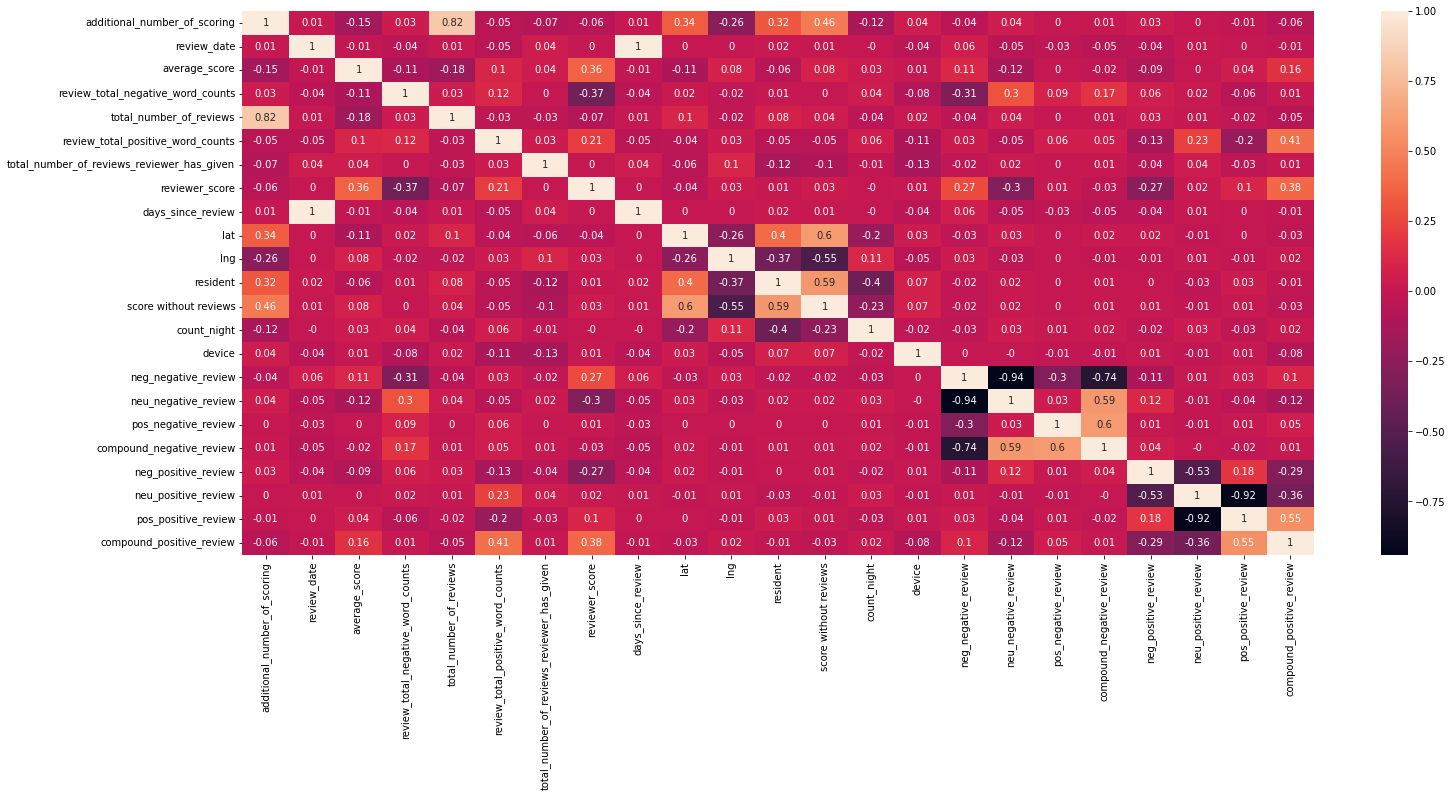

In [27]:
# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(hotels_train_clean.corr(), 2), annot = True)

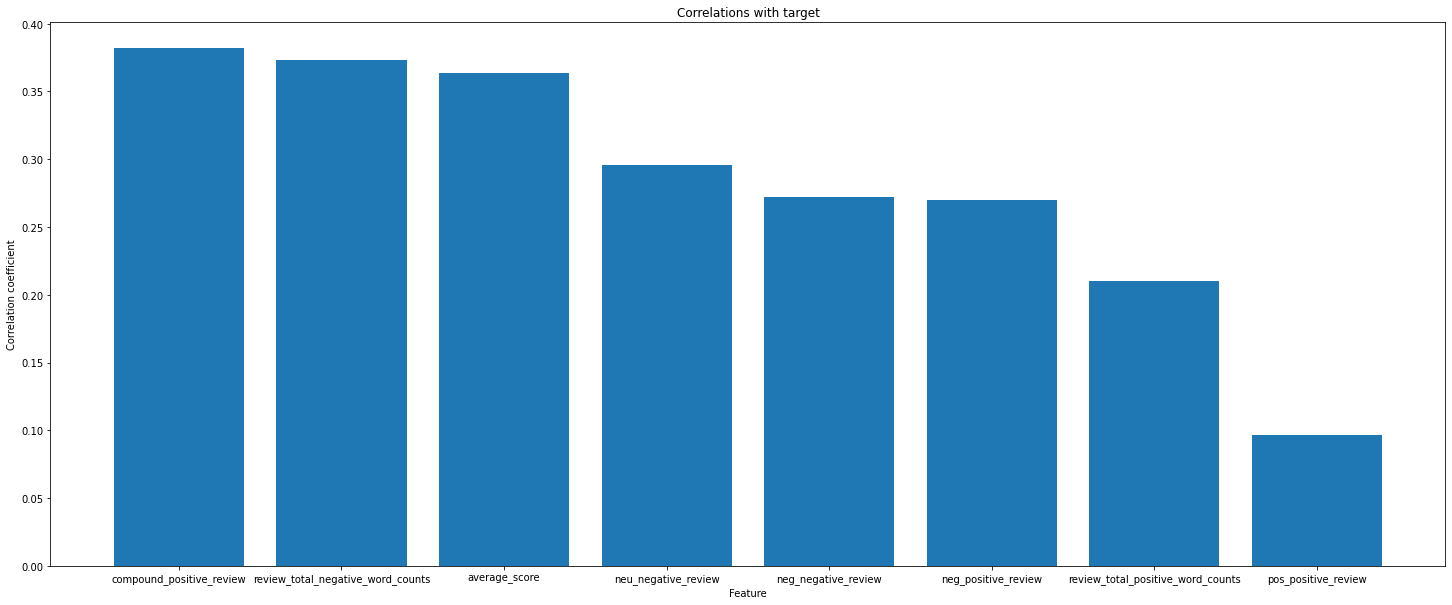

In [28]:
#Вычисляем модуль корреляции
corr_with_target = hotels_train_clean.corr()['reviewer_score'].abs().sort_values(ascending=False)[0:9]
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('reviewer_score')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(25, 10)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Из матрицы видно, что нет признаков мультиколлинеарных с целевым признаком 'review_score'. Наибольшая корелляция с признаками 'compound_positive_review', 'review_total_negative_word_counts', 'average_score', 'neu_negative_review', 'neg_negative_review'.

In [30]:
# выделим в кадом наборе данных списки с признаками типа 'object' для кодирования и дальнейшего удаления
object_columns_train_clean = [s for s in hotels_train_clean.columns if hotels_train_clean[s].dtypes == 'object']
object_columns_test_clean = [s for s in hotels_test_clean.columns if hotels_test_clean[s].dtypes == 'object']

In [31]:
# для кодирования используем бинарное кодирование
# кодирование данных тренировочной выборки
bin_encoder_train = ce.BinaryEncoder(cols=object_columns_train_clean) 
type_bin_train = bin_encoder_train.fit_transform(hotels_train_clean[object_columns_train_clean])
hotels_train_clean = pd.concat([hotels_train_clean, type_bin_train], axis=1)
# кодирование данных тестовой выборки
bin_encoder_test = ce.BinaryEncoder(cols=object_columns_test_clean) # указываем столбцы для кодирования тестовой выборки
type_bin_test = bin_encoder_test.fit_transform(hotels_test_clean[object_columns_test_clean])
hotels_test_clean = pd.concat([hotels_test_clean, type_bin_test], axis=1)
# удаляем лишние признаки
hotels_train_clean = hotels_train_clean.drop(object_columns_train_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop(object_columns_test_clean, axis=1)
hotels_test_clean = hotels_test_clean.drop('reviewer_score', axis=1)

In [32]:
# производим нормализацию данных
X = hotels_train_clean.drop(['reviewer_score'], axis = 1)
y = hotels_train_clean['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

hotels_test_clean_stand = mm_scaler.transform(hotels_test_clean)

In [33]:
# Построим модель на новом наборе признаков

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
# предсказания рейтинга для сабмишена
y_pred_test = regr.predict(hotels_test_clean_stand)

In [35]:
# Оцениваем качество модели по метрике MAPE, сравниваем предсказанные значения (y_pred) с реальными (y_test_tr)ий от фактических.  
print(f'MAPE:{metrics.mean_absolute_percentage_error(y_test, y_pred):.4f}')

MAPE:0.1251


In [36]:
# сформируем финальный сабмишен
sample_submission['reviewer_score'] = y_pred_test
sample_submission.to_csv('final_submission.csv', index=False)

Сабмишен показал результат Score: 12.61847